##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [ ]:
# Feel free to change these parameters according to your system's configuration
top_k = 5000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
attention_features_shape = 64
max_length = 48
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a silver island sit <end>


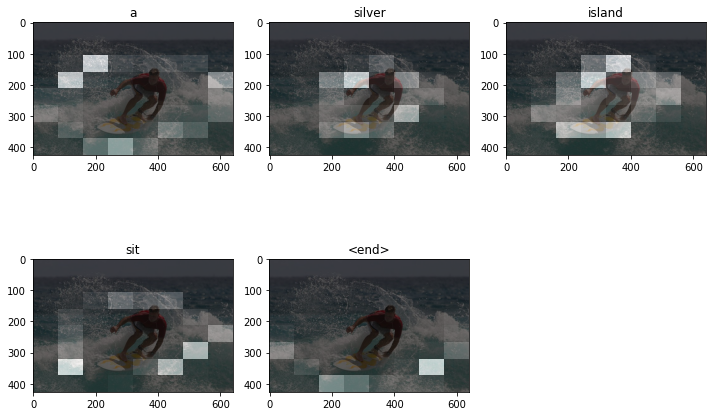

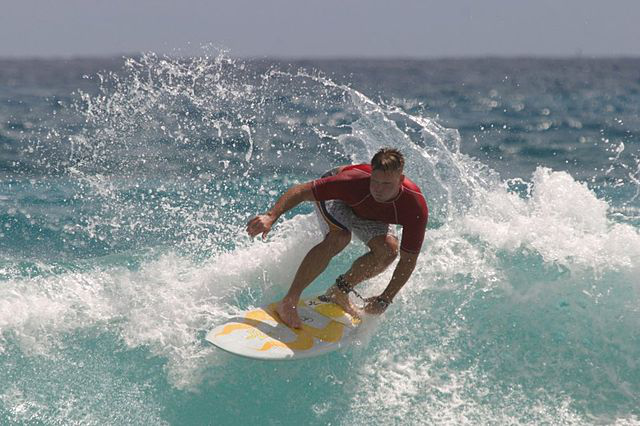

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.